# 1 - Image in spatial and frequency domain

Primeiramente é retirada a imagem a partir de requisição da URL e salva no formato jpg, após isso é selecionado uma resolução para fazer um fatiamento da imagem, gerando a variável "img_slice". Este processo é analógo ao "recebimento" de um frame de vídeo. Gerando o primeiro quadro. Neste caso, em relação ao codec H.264, seria possível apenas a predição intraquadro, pois é possível analisar apenas as características da própria imagem, caso fosse um vídeo seria possível a predição interquadros.

In [23]:
#importanto bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
#from scipy.misc import bytescale
from skimage.util import img_as_ubyte
import matplotlib.image as mpimg

In [24]:
#Salvando arquivo da imagem
import requests

# choice img from internet
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTQ8i-hBB9Hdl3zdy4SBRZNK6GLjIOgU3hhOQ&usqp=CAU"

# download and save image
response = requests.get(url)
if response.status_code == 200:
    with open("figure.jpg", 'wb') as f:
        f.write(response.content)

In [25]:
# lendo imagem
img = mpimg.imread('figure.jpg')

choosen_y_x = 51
resolution = 128

# fazendo fatiamento da imagem
img_slice = img[choosen_y_x:(choosen_y_x + resolution), choosen_y_x:(choosen_y_x + resolution), 2]

# 2 - DCT freq and Inversed DCT image

A segunda parte do codec H.264 é a transformação e quantização do sinal, abaixo é mostrado a utilização da transformada discreta do cosseno para levar a imagem do domínio espacial para o domínio da frequência, é possível perceber que após feita a transformada direta e inversa a imagem é praticamente igual a original, o que garante que essa transformada pode ser muito bem utilizada no nosso codec;

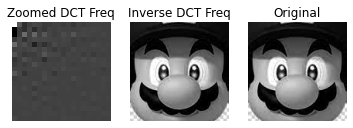

In [26]:
#Aplicando a transformada da imagem fatiada
# transform: 2D DCT
dct_slice = fftpack.dct(fftpack.dct(img_slice.T, norm='ortho').T, norm='ortho')
#Aplicando a transformada ivnersa
# inverse transform: 2D IDCT
idct_slice = fftpack.idct(fftpack.idct(dct_slice.T, norm='ortho').T, norm='ortho')

f, (plt1, plt2, plt3) = plt.subplots(1, 3)

plt1.axis('off'); plt1.set_title('Zoomed DCT Freq'); plt1.imshow(dct_slice[0:20,0:20], cmap='gray', interpolation='nearest');
plt2.axis('off'); plt2.set_title('Inverse DCT Freq'); plt2.imshow(idct_slice, cmap='gray');
plt3.axis('off'); plt3.set_title('Original'); plt3.imshow(img_slice, cmap='gray');

# 3 - Discarding 80% of the coefficients

Já entendemos a transformada, mas o objetivo principal de um codificador lossy é a retirada de informação que possibilite  o transporte de grandes quantidades de dados, mas que mantenha as características originais do frame, utilizando o fato de que a transformada discreta do cosseno possui energia muito mais alta nas suas componentes de baixa frequência é possível descartar grande parte dos dados e ainda manter a identidade visual.

86% of the coefficients were discarded.


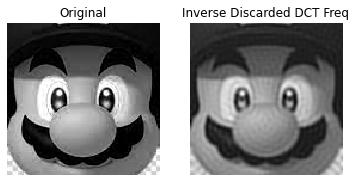

In [27]:
# Copiando DCT
dct_slice_copy = np.copy(dct_slice)

# Selecionando apenas as frequências principais
triangle = (50/100) * resolution

# only discard greater than threshold
threshold = 0.0019

discarded_coefficients = 0

#Descartando coeficientes para a compressão
for x in range(resolution):
    for y in range(resolution):
        if ((x +  y) > triangle) and (abs(dct_slice_copy[x, y]) > threshold):
            dct_slice_copy[x, y] = 0
            discarded_coefficients += 1

#Transformada ivnersa
# 2D inverse DCT            
idct_slice = fftpack.idct(fftpack.idct(dct_slice_copy.T, norm='ortho').T, norm='ortho')

f, (plt1, plt2) = plt.subplots(1, 2)

plt1.axis('off'); plt1.set_title('Original'); plt1.imshow(img_slice, cmap='gray', interpolation='nearest')
plt2.axis('off'); plt2.set_title('Inverse Discarded DCT Freq'); plt2.imshow(idct_slice, cmap='gray', interpolation='nearest')


print("%d%% of the coefficients were discarded." % ((discarded_coefficients / (resolution*resolution)) * 100))

# 4 - Understanding DCT

Como explicado anteriormente, a DCT nada mais é que uma operação que transforma um vetor do domínio do tempo para o domínio da frequência, esta operação utiliza o fato de que uma imagem pode ser representada pela intensidade dos seus pixels e aplicando a transformada nestes blocos. É fácil notar que na DCT as linhas e colunas iniciais possuem coeficientes maiores, que vão diminuindo progressivamente. Este é o motivo dela ser tão útil para a compressão.

In [28]:
#importando biblioteca
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
# from scipy.misc import bytescale
from skimage.util import img_as_ubyte
import matplotlib.image as mpimg

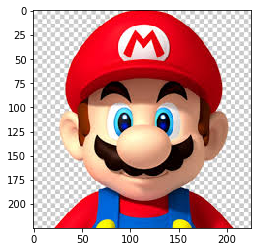

In [29]:
#Mostrando imagem
# loading a simple Z character image (8x8)
img = img_as_ubyte(mpimg.imread('figure.jpg'))
img_h = 8
gray_img = img[:,:,0]

plt.imshow(img, cmap='gray', interpolation='nearest')

## All pixel's value

In [30]:
np.set_printoptions(precision=1, linewidth=140, suppress=True)
gray_img

array([[246, 255, 255, ..., 229, 242, 255],
       [255, 255, 255, ..., 236, 255, 255],
       [255, 255, 253, ..., 236, 249, 250],
       ...,
       [230, 235, 234, ..., 228, 235, 232],
       [247, 255, 247, ..., 231, 255, 252],
       [255, 254, 255, ..., 225, 255, 255]], dtype=uint8)

## All coefficient's value

In [31]:
# transform: 2D DCT
z_dct = fftpack.dct(fftpack.dct(gray_img.T, norm='ortho').T, norm='ortho')

np.set_printoptions(precision=1, linewidth=140, suppress=True)
z_dct

array([[43854.3,  2359.9,  4824.7, ...,    -4.4,     5.2,   -26.2],
       [ 3672.5,  -434.8, -3378.9, ...,    -9.7,    -6.9,    -9.1],
       [ 1307.2,  -339.6,   108.3, ...,    -2.9,     2.6,    35. ],
       ...,
       [   -4.9,     3.6,    11.3, ...,     6.8,    -3.7,    -4.8],
       [    3.5,     2. ,   -11.8, ...,    -0.8,    -2.5,    -4.3],
       [   -2.1,    -2.1,     8.4, ...,    -0.1,    -4.5,     6. ]])

## 5 - DCT basis

É interessante notar então que as imagens podem ser transformadas para o domínio da frequência contanto que tenha-se a matriz adequada para fazer a transformação, isso se torna mais simples graças s Funções bases, que nada mais são que as matrizes pré-armazenadas normalmente de tamanho 8x8 que são utilizadas para fazer a transformação por etapas da imagem.

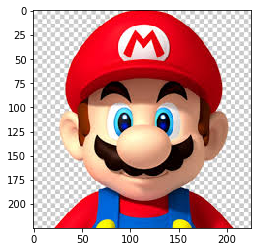

In [32]:
dct_basis = img_as_ubyte(mpimg.imread('figure.jpg'))
plt.imshow(dct_basis, cmap='gray', interpolation='nearest')

## 6 - Reconstructed images

Como anteriormente falado, a DCT em si nada mais é que o conjunto de várias funções base que vão sendo aplicadas por etapa aos blocos da nossa imagem, abaixo é mostrado os elementos da imagem enquanto vai sendo aplicado a transformação para cada bloco de 8x8

In [33]:
partial_z_idct = []
partial_z_dct = []

for ii in range(img_h*img_h):
    dct_copy = np.copy(z_dct)
    frequency_counter = 0 
    
    for u in range(img_h):
        for v in range(img_h):
            if frequency_counter > ii:
                dct_copy[u,v] = 0
            frequency_counter += 1
            
    partial_z_dct.append(dct_copy)
    
    partial_img_idct = fftpack.idct(fftpack.idct(dct_copy.T, norm='ortho').T, norm='ortho')
    partial_z_idct.append(partial_img_idct)

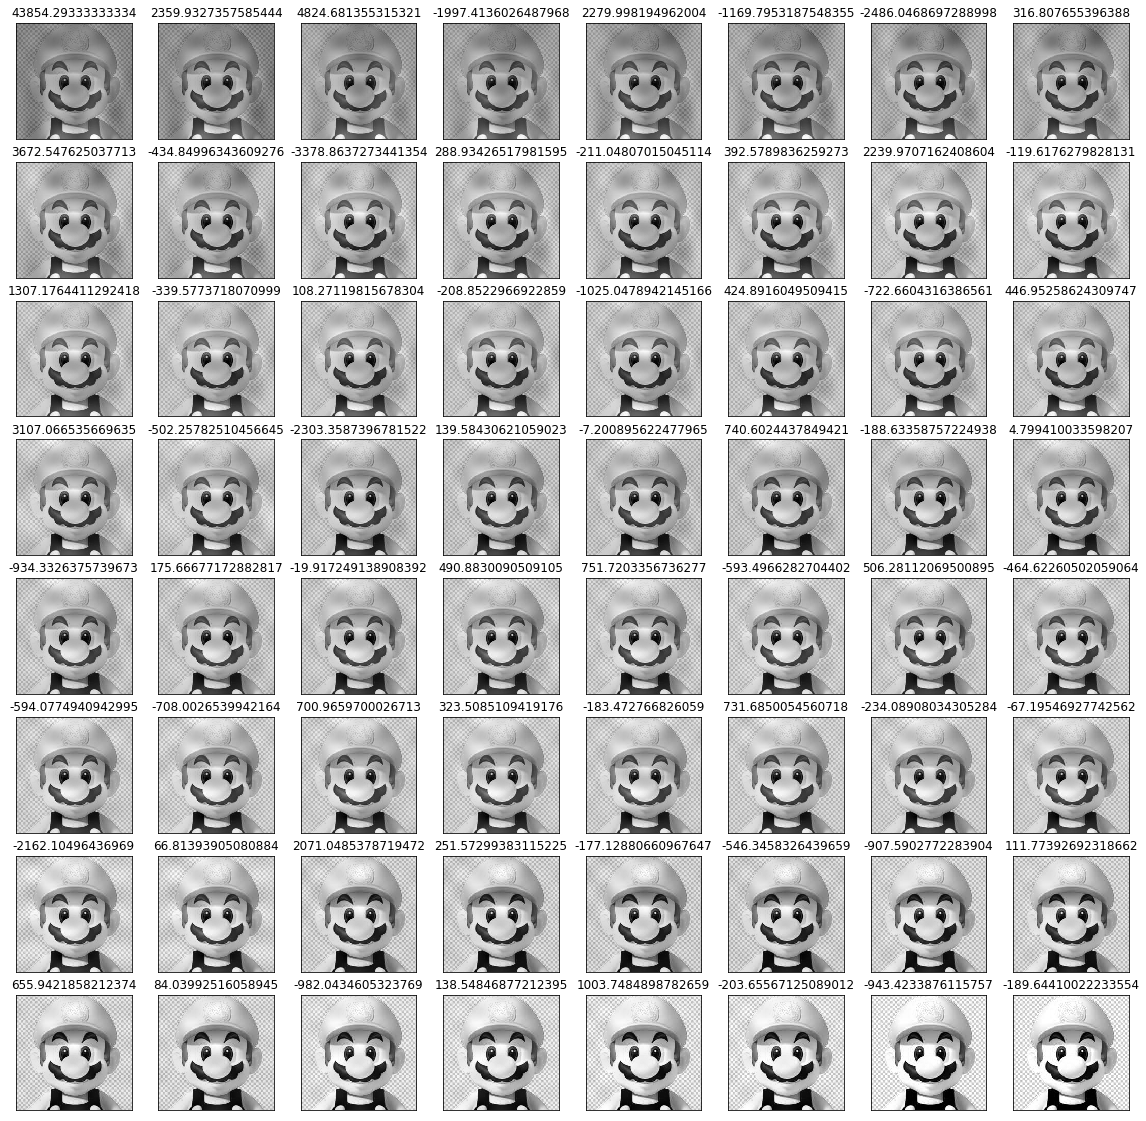

In [34]:
# shows each coefficient evolution towards the image formation
# here you can see how each DCT basis constributes to the image formation
# try to visualize them as a summation of the basis throughout the 64 elements 
fig = plt.figure(figsize=(20, 20))
for ii in range(img_h*img_h):
    plt.subplot(8, 8, ii + 1)
    plt.title(partial_z_dct[ii][int(ii / 8), ii % 8])
    plt.imshow(partial_z_idct[ii], cmap='gray', interpolation='nearest')
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);